### This notebook will demonstrate a simple phenotypic selection breeding program.

We will compare how phenotypic selection performs between two factors for a single trait with: 

 - heritability (.2 and .6)

 - marker effects drawn from a Normal distribution verus Gamma distribution


The gamma distribution creates more markers with effects closer to 0 with some markers with larger effects compared to a normal distribution

In [4]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import quick_haplo, combine_populations, Population, subset_population # Add subset_population


In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 100,
    "n_chr": 2,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 5,
    "population_size": 100,
    "n_select": 20,
    "key": jax.random.PRNGKey(42)
}
# ====

# --- Setup Founder Population and Traits using Parameters ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)

# Create SimParam objects for sp1 (Normal) and sp2 (Gamma)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=False
)

sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key, founder_pop=founder_pop, sim_param=sp2,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=True, shape=0.4
)

# Define the base templates for each simulation group
scenario_templates = [
    {"name_base": "sp1 (Normal)", "sp": sp1, "color": "blue"},
    {"name_base": "sp2 (Gamma)", "sp": sp2, "color": "green"}
]

# Define the heritabilities you want to test
h2_values_to_test = [0.1, 0.6]

# Dynamically assign colors for different h2 values if you want
# For simplicity, we can just alternate or use a predefined map.
h2_colors = {"0.1": "blue", "0.6": "red"} # Example color mapping


def run_simulation(key, founder_pop, sp, heritability, params):
    """Runs a breeding simulation for a given number of generations."""
    genetic_means = []
    genetic_variances = []
    current_pop = founder_pop
    next_id_start = current_pop.nInd
    n_generations = params["n_generations"]
    population_size = params["population_size"]
    n_select = params["n_select"]
    pheno_key, select_key, mate_key = jax.random.split(key, 3)

    for gen in range(n_generations + 1):
        p_subkey, pheno_key = jax.random.split(pheno_key)
        s_subkey, select_key = jax.random.split(select_key)
        m_subkey1, m_subkey2, mate_key = jax.random.split(mate_key, 3)
        current_pop = set_bv(current_pop, sp.traits, sp.ploidy)
        genetic_means.append(jnp.mean(current_pop.bv))
        genetic_variances.append(jnp.var(current_pop.bv))
        current_pop = set_pheno(
            key=p_subkey, pop=current_pop, traits=sp.traits,
            ploidy=sp.ploidy, h2=jnp.array([heritability])
        )
        selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-n_select:]
        mothers = jax.random.choice(m_subkey1, selected_indices, shape=(population_size,))
        fathers = jax.random.choice(m_subkey2, selected_indices, shape=(population_size,))
        cross_plan = jnp.stack([mothers, fathers], axis=1)
        current_pop = make_cross(
            key=s_subkey, pop=current_pop, cross_plan=cross_plan,
            sp=sp, next_id_start=next_id_start
        )
        next_id_start += population_size
    return genetic_means, genetic_variances

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)
founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=False
)
sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key, founder_pop=founder_pop, sim_param=sp2,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=True, shape=0.4
)

# --- Define Scenarios ---
scenario_templates = [
    {"name_base": "Normal", "sp": sp1, "color": "#0077BB"},
    {"name_base": "Gamma", "sp": sp2, "color": "#009988"}
]
h2_values_to_test = [0.1, 0.6]
h2_linestyles = {0.1: ':', 0.6: '-'}

scenarios = []
for template in scenario_templates:
    for h2 in h2_values_to_test:
        scenarios.append({
            "name": f"{template['name_base']}, h2={h2}",
            "sp": template['sp'], "h2": h2,
            "color": template['color'], "linestyle": h2_linestyles[h2]
        })

# --- Run Replicated Simulations ---
results = {s['name']: {'means': [], 'variances': []} for s in scenarios}
for i in range(simulation_parameters["n_replicates"]):
    key, rep_key = jax.random.split(key)
    print(f"--- Running Replicate {i+1}/{simulation_parameters['n_replicates']} ---")
    for scenario in scenarios:
        rep_key, sim_key = jax.random.split(rep_key)
        means, variances = run_simulation(
            key=sim_key, founder_pop=founder_pop, sp=scenario["sp"],
            heritability=scenario["h2"], params=simulation_parameters
        )
        results[scenario['name']]['means'].append(means)
        results[scenario['name']]['variances'].append(variances)



--- Running Replicate 1/3 ---
--- Running Replicate 2/3 ---
--- Running Replicate 3/3 ---


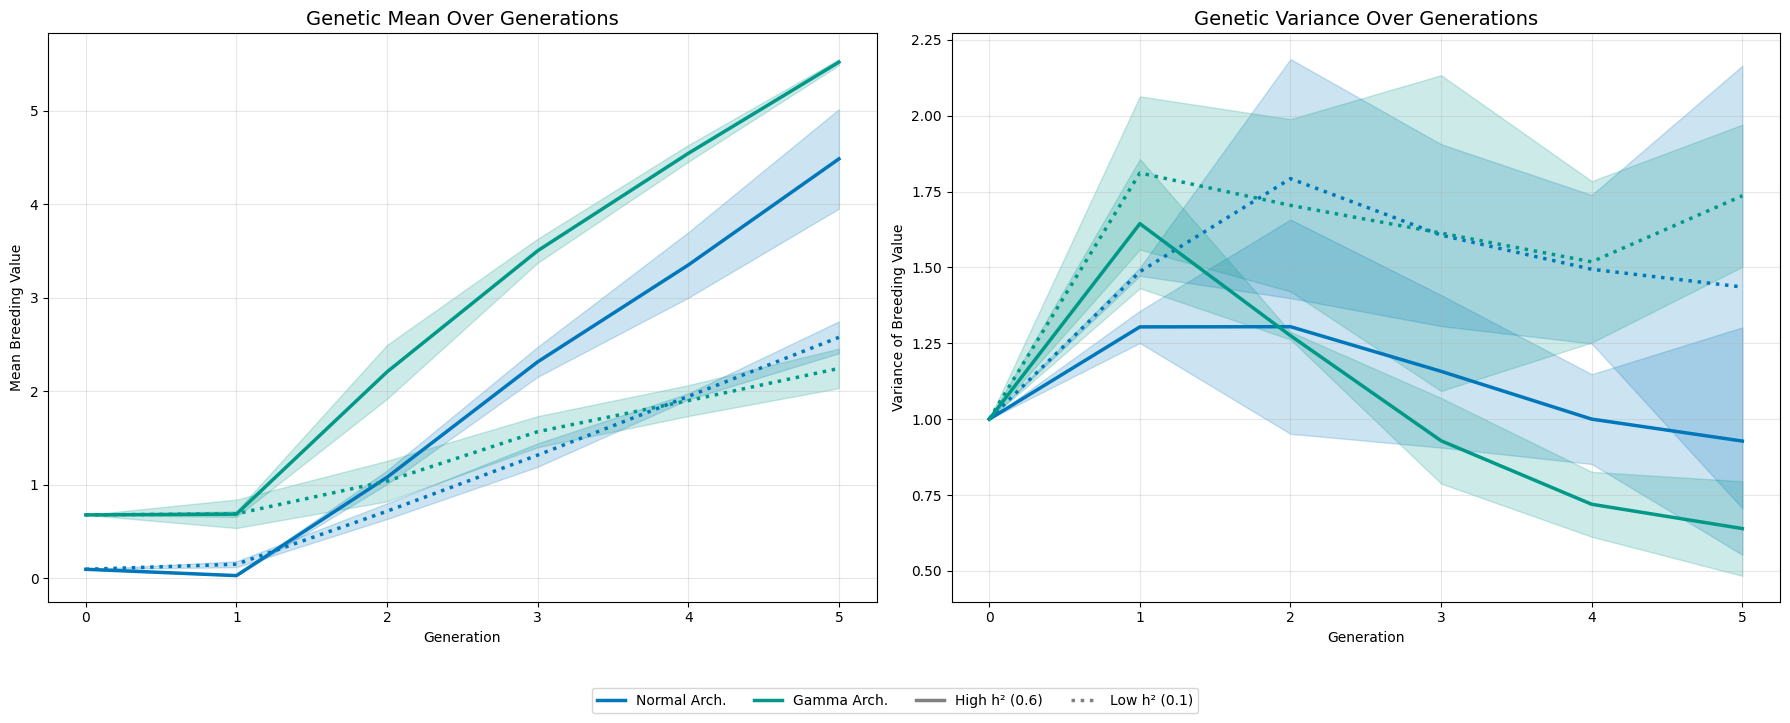

In [6]:

import numpy as np
import matplotlib.lines as mlines

# ==================================================
# --- Visualization with Confidence Intervals ---
# ==================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
generations = range(simulation_parameters["n_generations"] + 1)

# --- Plot 1: Genetic Mean ---
ax1.set_title("Genetic Mean Over Generations", fontsize=14)
for scenario in scenarios:
    name = scenario['name']
    # Calculate mean and std dev across replicates
    mean_of_means = np.mean(results[name]['means'], axis=0)
    std_of_means = np.std(results[name]['means'], axis=0)
    
    # Plot the mean line
    ax1.plot(generations, mean_of_means,
             linestyle=scenario["linestyle"], color=scenario["color"],
             linewidth=2.5)
    # Plot the confidence interval
    ax1.fill_between(generations,
                     mean_of_means - std_of_means,
                     mean_of_means + std_of_means,
                     color=scenario["color"], alpha=0.2)

ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Breeding Value")
ax1.grid(True, alpha=0.3)

# --- Plot 2: Genetic Variance ---
ax2.set_title("Genetic Variance Over Generations", fontsize=14)
for scenario in scenarios:
    name = scenario['name']
    # Calculate mean and std dev across replicates
    mean_of_vars = np.mean(results[name]['variances'], axis=0)
    std_of_vars = np.std(results[name]['variances'], axis=0)
    
    # Plot the mean line
    ax2.plot(generations, mean_of_vars,
             linestyle=scenario["linestyle"], color=scenario["color"],
             linewidth=2.5)
    # Plot the confidence interval
    ax2.fill_between(generations,
                     mean_of_vars - std_of_vars,
                     mean_of_vars + std_of_vars,
                     color=scenario["color"], alpha=0.2)

ax2.set_xlabel("Generation")
ax2.set_ylabel("Variance of Breeding Value")
ax2.grid(True, alpha=0.3)

# --- Create a single, clear, custom legend for the entire figure ---
legend_elements = [
    mlines.Line2D([], [], color='#0077BB', linestyle='-', lw=2.5, label='Normal Arch.'),
    mlines.Line2D([], [], color='#009988', linestyle='-', lw=2.5, label='Gamma Arch.'),
    mlines.Line2D([], [], color='gray', linestyle='-', lw=2.5, label='High h² (0.6)'),
    mlines.Line2D([], [], color='gray', linestyle=':', lw=2.5, label='Low h² (0.1)')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

### Selecting for a trait with marker effects drawn from a Gamma versus Normal distribution

The main finding from this simulation experiment is selecting for a trait with marker effects from a gamma distribution (smaller number of genes with larger effects) allows selection to perform better in the earlier stages, however, as these large effect markers become fixed, the amount of genetic variance decreases and stagnates, while the normal distribution still has genetic variance for selection to act upon.

The generation where the normal distribution overtakes the genetic gain depends on the heritability of the trait. Higher heritability allows for stronger selection accuracy, depleting the genetic variance earlier.